### Library Install and uninstall

In [1]:
!pip3 uninstall tensorflow -y

In [52]:
!pip3 install pandas numpy scikit-learn tqdm catboost optuna ipywidgets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [51]:
import accelerate
accelerate.__version__

'0.27.2'

### Import library

In [1]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification,Trainer
import transformers

In [2]:
import pandas as pd
from tqdm.notebook import tqdm
import sklearn
import numpy as np
import random
import os
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner
from catboost import CatBoostClassifier, Pool, CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.model_selection import StratifiedKFold
import re

import pandas as pd
import numpy as np
import os
import random

In [3]:
class newDataset:
    def __init__(self, torkenized_texts):
        self.tokenized_texts = tokenized_texts
    
    def __len__(self):
        return len(self.tokenized_texts["input_ids"])
    
    def __getitem__(self, idx):
        return {k:v[idx] for k, v in self.tokenized_texts.items()}
    
model_name = 'j-hartmann/emotion-english-distilroberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

In [4]:
file_name = 'train.csv'
text_column = 'lead_description'
df_pred = pd.read_csv(file_name)
df_pred[text_column] = df_pred[text_column].fillna('NAN')
pred_texts = df_pred[text_column].dropna().astype('str').tolist()

In [5]:
tokenized_texts = tokenizer(pred_texts, truncation=True,padding=True)
pred_texts = newDataset(tokenized_texts)

In [6]:
predictions = trainer.predict(pred_texts)

In [7]:
# Transform predictions to labels
preds = predictions.predictions.argmax(-1)
labels = pd.Series(preds).map(model.config.id2label)
scores = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [8]:
temp = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True))

In [9]:
# work in progress
# container
anger = []
disgust = []
fear = []
joy = []
neutral = []
sadness = []
surprise = []

# extract scores (as many entries as exist in pred_texts)
for i in range(len(pred_texts)):
    anger.append(temp[i][0])
    disgust.append(temp[i][1])
    fear.append(temp[i][2])
    joy.append(temp[i][3])
    neutral.append(temp[i][4])
    sadness.append(temp[i][5])
    surprise.append(temp[i][6])

In [10]:
# Create DataFrame with texts, predictions, labels, and scores
df = pd.DataFrame(list(zip(pred_texts,preds,labels,scores,  anger, disgust, fear, joy, neutral, sadness, surprise)), columns=['text','pred','label','score', 'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'])
df.head()

,text,pred,label,score,anger,disgust,fear,joy,neutral,sadness,surprise
0,"{'input_ids': [0, 487, 1889, 2, 1, 1, 1, 1, 1,...",4,neutral,0.715612,0.024700,0.048721,0.013289,0.014079,0.715612,0.076745,0.106854
1,"{'input_ids': [0, 13755, 89, 143, 7752, 13, 80...",4,neutral,0.840949,0.005893,0.004173,0.004368,0.003194,0.840949,0.017645,0.123777
2,"{'input_ids': [0, 487, 1889, 2, 1, 1, 1, 1, 1,...",4,neutral,0.715612,0.024700,0.048721,0.013289,0.014079,0.715612,0.076745,0.106854
3,"{'input_ids': [0, 23314, 17560, 8, 37196, 2262...",4,neutral,0.800774,0.022500,0.010692,0.044287,0.066880,0.800774,0.040081,0.014786
4,"{'input_ids': [0, 21959, 2, 1, 1, 1, 1, 1, 1, ...",4,neutral,0.688904,0.098272,0.067341,0.067151,0.014987,0.688904,0.019344,0.044001


In [11]:
df = df[['anger','disgust','fear','joy','neutral','sadness','surprise']]

In [52]:
len(df)

21341

In [12]:
df.to_csv('train_emotion.csv',index=False)

In [ ]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification,Trainer
import transformers

In [13]:
file_name = 'submission.csv'
text_column = 'lead_description'
df_pred = pd.read_csv(file_name)
df_pred[text_column] = df_pred[text_column].fillna('NAN')
pred_texts = df_pred[text_column].dropna().astype('str').tolist()

In [14]:
model_name = 'j-hartmann/emotion-english-distilroberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)
tokenized_texts = tokenizer(pred_texts, truncation=True,padding=True)
pred_texts = newDataset(tokenized_texts)

In [15]:
predictions = trainer.predict(pred_texts)

In [16]:
# Transform predictions to labels
preds = predictions.predictions.argmax(-1)
labels = pd.Series(preds).map(model.config.id2label)
scores = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [17]:
temp = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True))

In [18]:
# work in progress
# container
anger = []
disgust = []
fear = []
joy = []
neutral = []
sadness = []
surprise = []

# extract scores (as many entries as exist in pred_texts)
for i in range(len(pred_texts)):
    anger.append(temp[i][0])
    disgust.append(temp[i][1])
    fear.append(temp[i][2])
    joy.append(temp[i][3])
    neutral.append(temp[i][4])
    sadness.append(temp[i][5])
    surprise.append(temp[i][6])

In [19]:
# Create DataFrame with texts, predictions, labels, and scores
df = pd.DataFrame(list(zip(pred_texts,preds,labels,scores,  anger, disgust, fear, joy, neutral, sadness, surprise)), columns=['text','pred','label','score', 'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'])
df.head()

,text,pred,label,score,anger,disgust,fear,joy,neutral,sadness,surprise
0,"{'input_ids': [0, 487, 1889, 2, 1, 1, 1, 1, 1,...",4,neutral,0.715612,0.024700,0.048721,0.013289,0.014079,0.715612,0.076745,0.106854
1,"{'input_ids': [0, 118, 33, 41, 793, 467, 240, ...",5,sadness,0.936021,0.011519,0.001132,0.003908,0.005819,0.014641,0.936021,0.026960
2,"{'input_ids': [0, 9112, 40455, 3842, 36759, 37...",4,neutral,0.916403,0.027019,0.005466,0.004710,0.006501,0.916403,0.018432,0.021469
3,"{'input_ids': [0, 41257, 2319, 1229, 2, 1, 1, ...",4,neutral,0.854739,0.009136,0.003865,0.005798,0.010212,0.854739,0.051155,0.065095
4,"{'input_ids': [0, 15833, 4932, 13, 275, 425, 6...",4,neutral,0.899226,0.021235,0.004996,0.006930,0.018254,0.899226,0.013417,0.035941


In [74]:
df = df[['anger','disgust','fear','joy','neutral','sadness','surprise']]

In [75]:
df.to_csv('test_emotion.csv',index=False)

In [175]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed=42
seed_everything(seed) # Seed 고정

In [176]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [177]:
df_emotion = pd.read_csv('train_emotion.csv')
df_t_emotion = pd.read_csv('test_emotion.csv')

In [178]:
df_train = pd.concat([df_train,df_emotion],axis=1)
df_test = pd.concat([df_test, df_t_emotion],axis=1)

In [179]:
def find_int(text):
    return re.findall(r'\d+', str(text))

def find_str(text):
    label = 0
    if 'ongoing' in str(text):
        label = 1
    elif 'more' in str(text):
        label = 1
    return label

def tmp_1(text):
    a = str(text).split('_')
    try:
        return a[0]
    except:
        return 'NAN'
    
def tmp_2(text):
    a = str(text).split('_')
    try:
        return a[1]
    except:
        return 'NAN'
    
def tmp_3(text):
    a = str(text).split('_')
    try:
        return a[2]
    except:
        return 'NAN'
    
    
def category_all(df_train, df_test):
    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
   'customer_idx',
   'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    #new
    "lead_from_channel",
    "is_lead_description",
#     "lead_date_year",
#     "lead_date_quarter",
#     "lead_date_dayofyear",
#     "lead_date_month",
#     "lead_date_dayofweek",
#     "lead_date_day",
    "event_name",
    "transfer_agreement",
    #"expected_budget",
    "customer_country",
    "ver_win_rate_mean_upper",
    "customer_history",
        'bant_submit_cate',
        'expected_budget',
        'event_name_1',
        'event_name_2',
        'event_name_3'
    ]

    for i in label_columns:
        df_train[i] = df_train[i].astype('category')
        df_test[i] = df_test[i].astype('category')
    return df_train, df_test    


def preprocessing(df_train, df_test):
    df_train.drop_duplicates(keep='first', inplace=True)
    df_train.reset_index(inplace=True)
    df_train.drop('index',inplace=True, axis=1)
    df_test_id_temp = df_test['id'].copy()
    df_all = pd.concat([df_train,df_test.drop('id',axis=1)])
    df_all.drop('customer_country.1',axis=1,inplace=True)
    df_all.id_strategic_ver.fillna(0., inplace=True)
    df_all.it_strategic_ver.fillna(0., inplace=True)
    df_all.idit_strategic_ver.fillna(0., inplace=True)
    df_all.business_subarea.fillna('NAN', inplace=True)
    df_all.com_reg_ver_win_rate.fillna(0,inplace=True)
    df_all['customer_type'] = df_all['customer_type'].replace({
        'End-Customer':'End Customer'
    })
    df_all.customer_type.fillna('NAN',inplace=True)
    df_all.historical_existing_cnt.fillna(0, inplace=True)
    
    df_all.product_subcategory.fillna('NAN', inplace=True)
    
    df_all.product_modelname.fillna('NAN', inplace=True)

    df_all['expected_timeline'] = df_all['expected_timeline'].replace({
        'less_than_3_months': 'less than 3 months',
        'being followed up': 'being followed up.',
        'less than 6 months': '3 months ~ 6 months',
        '3_months_~_6_months' : '3 months ~ 6 months'
    })
    
    ###########
    df_all['event_name_1'] = df_all['event_name'].apply(tmp_1)
    df_all['event_name_2'] = df_all['event_name'].apply(tmp_2)
    df_all['event_name_3'] = df_all['event_name'].apply(tmp_3)
    ##########

    df_all.expected_timeline.fillna('NAN',inplace=True)
    df_all.ver_win_rate_x.fillna(0,inplace=True)
    df_all.ver_win_ratio_per_bu.fillna(0,inplace=True)
    df_all.business_area.fillna('NAN',inplace=True)
    df_all.customer_job.fillna('NAN', inplace=True)
    df_all.product_category.fillna('NAN', inplace=True)
    df_all['bant_submit_cate'] = df_all['bant_submit']*4
    df_all['bant_submit_cate'] = df_all['bant_submit_cate'].astype('int64')
    
    ####new Feature
    df_all.lead_from_channel.fillna('NAN',inplace=True)
    df_all['is_lead_description'] = np.where(df_all['lead_description'].isna()==True,0,1)
    df_all.drop(labels="lead_description",axis=1,inplace=True)
#     df_all['lead_date_quarter'] = pd.to_datetime(df_all['lead_date']).dt.quarter
#     df_all['lead_date_year'] = pd.to_datetime(df_all['lead_date']).dt.year
#     df_all['lead_date_dayofyear'] = pd.to_datetime(df_all['lead_date']).dt.dayofyear
#     df_all['lead_date_month'] = pd.to_datetime(df_all['lead_date']).dt.month
#     df_all['lead_date_dayofweek'] = pd.to_datetime(df_all['lead_date']).dt.dayofweek
#     df_all['lead_date_day'] = pd.to_datetime(df_all['lead_date']).dt.day
    df_all.event_name.fillna("NAN", inplace=True)
    df_all.prefer_ver_count.fillna(0,inplace=True)
    df_all.prefer_ver_mean.fillna(0,inplace=True)
    df_all['transfer_agreement'] = np.where(df_all['transfer_agreement'].isna()==True,'M',df_all['transfer_agreement'])
    df_all.ver_win_rate_mean_upper.fillna(0, inplace=True)
    df_all.expected_budget.fillna('NAN', inplace=True)
    df_all.drop(labels='lead_date',axis=1,inplace=True)
    
    #처리못한부분
    #customer_country
    df_all.customer_country.fillna('NAN', inplace=True)
    #inquiry_type
    df_all.inquiry_type.fillna('NAN', inplace=True)

    label_columns = [
        "customer_country",
        "business_subarea",
        "business_area",
        "business_unit",
        "customer_type",
        "enterprise",
        "customer_job",
        "inquiry_type",
        "product_category",
        "product_subcategory",
        "product_modelname",
        "customer_position",
        "response_corporate",
        "expected_timeline",
        "lead_from_channel",
        #new
        "event_name",
        "customer_history",

    ]
    
    ###############################
    df_all['expected_budget_int'] = df_all['expected_budget'].str.replace(".","")
    df_all['expected_budget_int'] = df_all['expected_budget_int'].str.replace(",","")
    tmp = df_all['expected_budget_int'].apply(find_int)
    x = []
    for i in tmp:
        if(len(i)==0):
            i = int(0)
        else:
            i = int(i[0])
        if(i==1 or i == 10):
            x.append(i*1000000)
        else:
            x.append(i)
    df_all['expected_budget_int'] = x
    
    df_all['expected_budget'] = df_all['expected_budget'].str.lower()
    df_all['expected_budget'] = df_all['expected_budget'].str.replace(pat=r'[^\w]', repl=r'', regex=True)
    df_all['expected_budget'] = df_all['expected_budget'].apply(find_str)
    
    
    #detect special char and to lower
    for i in label_columns:
        df_all[i] = df_all[i].str.lower()
        df_all[i] = df_all[i].str.replace(pat=r'[^\w]', repl=r'', regex=True)
        
    #to int
    df_all['id_strategic_ver'] = df_all['id_strategic_ver'].astype('int64')
    df_all['it_strategic_ver'] = df_all['it_strategic_ver'].astype('int64')
    df_all['idit_strategic_ver'] = df_all['idit_strategic_ver'].astype('int64')
    df_all['lead_desc_length'] = df_all['lead_desc_length'].astype('int64')
    df_all['historical_existing_cnt'] = df_all['historical_existing_cnt'].astype('int64')
    
    df_all['ver_win_rate_mean_upper'] = df_all['ver_win_rate_mean_upper'].astype('int64')
    df_all['historical_existing_cnt_log'] = np.log1p(df_all['historical_existing_cnt'])
    #seperate
    tmp_len = len(df_train)
    df_train = df_all.iloc[: tmp_len ]
    df_test = df_all.iloc[tmp_len :]
    df_test = pd.concat([df_test,df_test_id_temp],axis=1)

#     Scaler = StandardScaler()
#     df_train['ver_win_rate_x_s'] = Scaler.fit_transform(df_train[['ver_win_rate_x']])
#     df_test['ver_win_rate_x_s'] = Scaler.transform(df_test[['ver_win_rate_x']])
#     Scaler = StandardScaler()
#     df_train['ver_win_ratio_per_bu_s'] = Scaler.fit_transform(df_train[['ver_win_ratio_per_bu']])
#     df_test['ver_win_ratio_per_bu_s'] = Scaler.transform(df_test[['ver_win_ratio_per_bu']])
#     Scaler = StandardScaler()
#     df_train['com_reg_ver_win_rate_s'] = Scaler.fit_transform(df_train[['com_reg_ver_win_rate']])
#     df_test['com_reg_ver_win_rate_s'] = Scaler.transform(df_test[['com_reg_ver_win_rate']])
#     Scaler = StandardScaler()
#     df_train['prefer_ver_mean_s'] = Scaler.fit_transform(df_train[['prefer_ver_mean']])
#     df_test['prefer_ver_mean_s'] = Scaler.transform(df_test[['prefer_ver_mean']])
#     Scaler = StandardScaler()
#     df_train['prefer_ver_count_s'] = Scaler.fit_transform(df_train[['prefer_ver_count']])
#     df_test['prefer_ver_count_s'] = Scaler.transform(df_test[['prefer_ver_count']])
    ##############################
    
    return df_train, df_test


df_train, df_test = preprocessing(df_train, df_test)
df_train, df_test = category_all(df_train, df_test)
rate = ((len(df_train)-sum(df_train['is_converted']))/sum(df_train['is_converted']))
x_train, y_train = df_train.drop("is_converted",axis=1), df_train["is_converted"]

In [180]:
categorical_features = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
   'customer_idx',
   'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    #new
    "lead_from_channel",
    "is_lead_description",
#     "lead_date_year",
#     "lead_date_quarter",
#     "lead_date_year",
#     "lead_date_dayofyear",
#     "lead_date_month",
#     "lead_date_dayofweek",
#     "lead_date_day",
    "event_name",
    "transfer_agreement",
    "customer_country",
        "ver_win_rate_mean_upper",
        "customer_history",
    'bant_submit_cate',
    'expected_budget',
    'event_name_1',
        'event_name_2',
        'event_name_3'
    ]

S_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

all_train_pool = []
all_val_pool = []
all_y_val = []

for train_idx, val_idx in S_kfold.split(x_train, list(y_train)):
    tmp_x_train, tmp_x_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
    tmp_y_train, tmp_y_val = y_train[train_idx], y_train[val_idx]
    train_pool = Pool(data=tmp_x_train, label=tmp_y_train, cat_features=categorical_features)
    val_pool = Pool(data=tmp_x_val, label=tmp_y_val, cat_features=categorical_features)
    all_train_pool.append(train_pool)
    all_val_pool.append(val_pool)
    all_y_val.append(list(tmp_y_val))

In [182]:
# def objective(trial):
#     params = {
#         "iterations": 1000,
#         "depth": trial.suggest_int("depth", 7, 10),
#         "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0),
#         "random_strength": trial.suggest_float("random_strength", 1e-3, 1e-1, log=True),
#         "border_count": trial.suggest_int("border_count", 1, 255),
#         "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 1e2, log=True),
#         "leaf_estimation_iterations": trial.suggest_int("leaf_estimation_iterations", 1, 10),
#         "leaf_estimation_method": trial.suggest_categorical("leaf_estimation_method", ["Newton", "Gradient"]),
#         "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
#         "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
#         "one_hot_max_size": 1,
#         "random_state": seed,
#         "verbose": 0,
#     }
    
#     #score = []
#     tmp_score = []
#     for train_pool, val_pool, y_true in zip(all_train_pool, all_val_pool, all_y_val):
#         clf = CatBoostClassifier(**params,
#                                  scale_pos_weight=np.sqrt(rate), 
#                                  loss_function='Logloss',
#                                  eval_metric='F1',
#                                  early_stopping_rounds=100,
#                                  #task_type="GPU",
#                                 )
#         clf.fit(train_pool, eval_set=val_pool)
# #         y_pred = clf.predict(val_pool)
# #         y_pred = [False if i==0 else True for i in y_pred]
# #         tmp_score.append(f1_score(y_true,y_pred,labels=[True, False]))
#         tmp_score.append(clf.get_feature_importance()[5])
#     tmp_score = np.mean(tmp_score)
#     return tmp_score

# # Hyperparameter Tuning
# study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed), pruner=SuccessiveHalvingPruner())
# study.optimize(objective, n_trials=None)

In [204]:
param = {'depth': 8, 'learning_rate': 0.005514022014373036, 'random_strength': 0.08181679811022236, 'border_count': 6, 'l2_leaf_reg': 0.1612811154623469, 'leaf_estimation_iterations': 3, 'leaf_estimation_method': 'Newton', 'bootstrap_type': 'MVS', 'grow_policy': 'Depthwise', 'min_data_in_leaf': 78}

In [205]:

best_models = []
for train_pool, val_pool in zip(all_train_pool, all_val_pool):
    best_model = CatBoostClassifier(**param,
                                random_state=seed,
                                scale_pos_weight=np.sqrt(rate), 
                                loss_function='Logloss',
                                eval_metric='F1',
                                verbose=100,
                                early_stopping_rounds=100,
                                   one_hot_max_size=1)
    best_model.fit(train_pool, eval_set=val_pool)
    best_models.append(best_model)

0:	learn: 0.8661702	test: 0.8819976	best: 0.8819976 (0)	total: 27.7ms	remaining: 27.6s
100:	learn: 0.8850315	test: 0.8941395	best: 0.8975893 (24)	total: 1.28s	remaining: 11.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8975893428
bestIteration = 24

Shrink model to first 25 iterations.
0:	learn: 0.8702645	test: 0.8791621	best: 0.8791621 (0)	total: 28.3ms	remaining: 28.3s
100:	learn: 0.8809943	test: 0.8990349	best: 0.8990349 (100)	total: 1.31s	remaining: 11.7s
200:	learn: 0.8880551	test: 0.9004887	best: 0.9009308 (192)	total: 2.68s	remaining: 10.7s
300:	learn: 0.8927565	test: 0.9009308	best: 0.9027289 (253)	total: 4.05s	remaining: 9.41s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9027288505
bestIteration = 253

Shrink model to first 254 iterations.
0:	learn: 0.8722189	test: 0.8840027	best: 0.8840027 (0)	total: 28ms	remaining: 27.9s
100:	learn: 0.8803810	test: 0.9002407	best: 0.9002407 (100)	total: 1.3s	remaining: 11.6s
200:	learn: 0.887

In [206]:
categorical_features = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
   'customer_idx',
   'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    #new
    "lead_from_channel",
     "is_lead_description",
#     "lead_date_year",
#     "lead_date_quarter",
#     "lead_date_year",
#     "lead_date_dayofyear",
#     "lead_date_month",
#     "lead_date_dayofweek",
#     "lead_date_day",
    "event_name",
    "transfer_agreement",
    "expected_budget",
    "customer_country",
        "ver_win_rate_mean_upper",
        "customer_history",
    'bant_submit_cate',
    'expected_budget',
    'event_name_1',
        'event_name_2',
        'event_name_3'
    ]
# 
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)
test_pool = Pool(data=x_test, cat_features=categorical_features)


In [207]:
# 예측 수행 (soft voting)
pred = [best_model.predict_proba(test_pool) for best_model in best_models]
pred = np.mean(pred, axis=0)
cpu_pred = np.argmax(pred, axis=1)

In [208]:
# big=0
# big_num=0
# for i in tqdm(np.arange(0.5,0.9,0.01)):
#     tmp_score=[]
#     for val_pool, y_true,best_model in zip(all_val_pool, all_y_val, best_models):
#         y_pred = best_model.predict_proba(val_pool)
#         y_pred = np.where(y_pred[:,1]>i,True,False)
#         tmp_score.append(f1_score(y_true,y_pred,labels=[True, False]))
#     tmp_score = np.mean(tmp_score)
#     if big < tmp_score:
#         big = tmp_score
#         big_num=i
# # print(big, big_num)

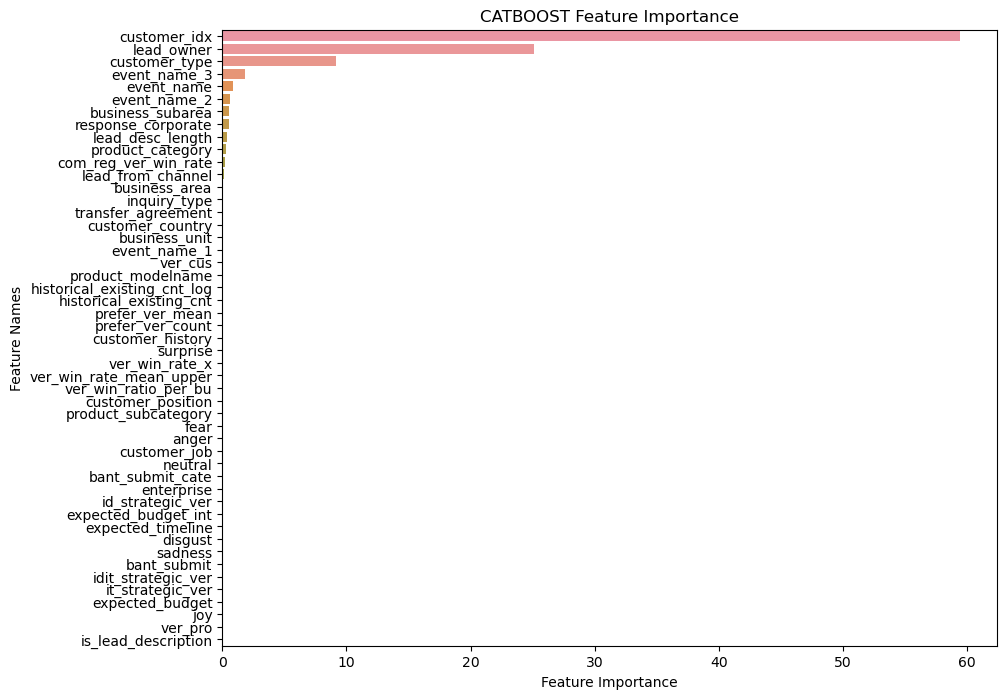

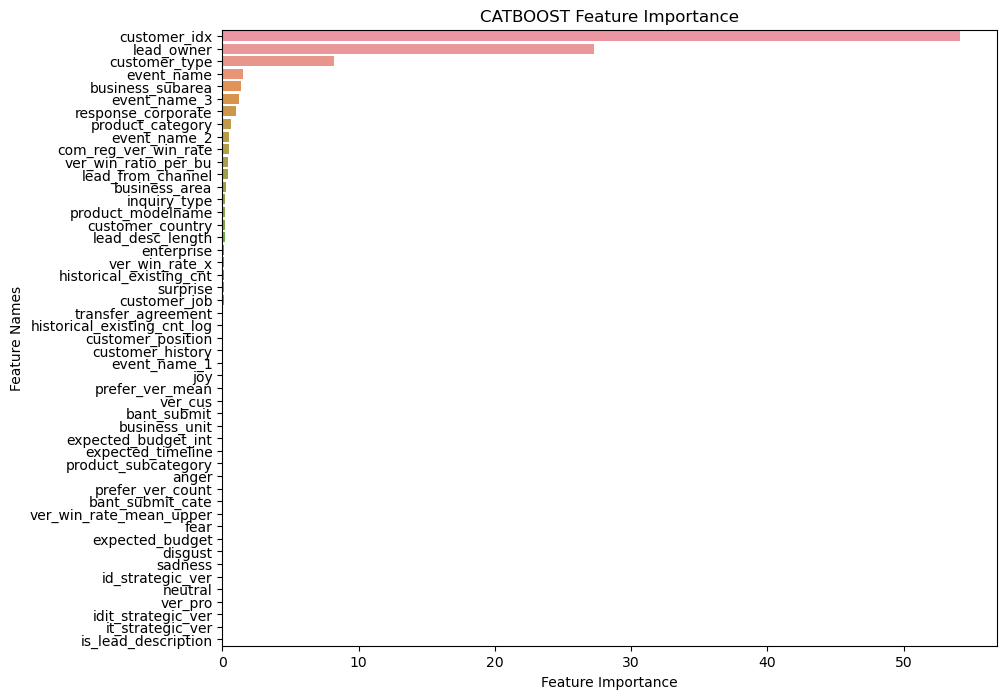

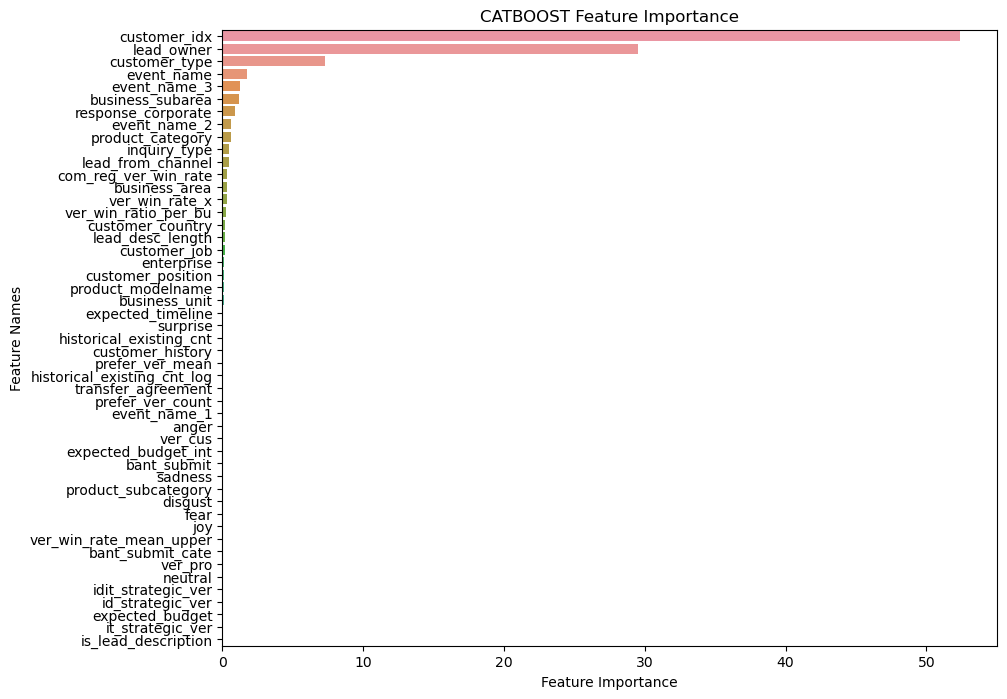

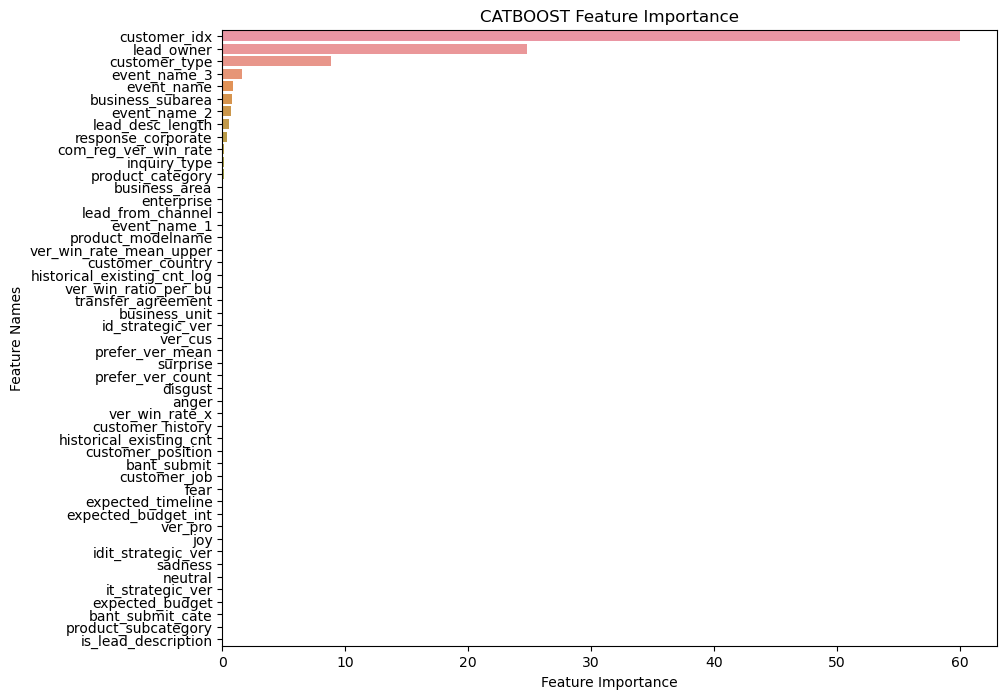

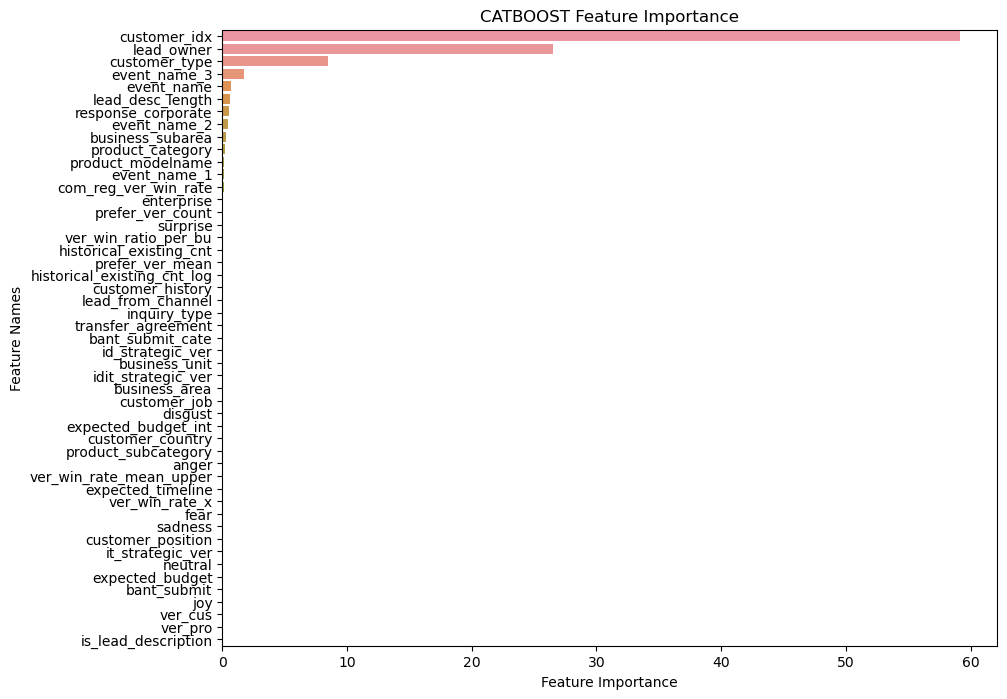

In [214]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
for i in best_models:
    plot_feature_importance(i.get_feature_importance(),df_test.drop(['is_converted','id'],axis=1).columns,'CATBOOST')

In [209]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = cpu_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [210]:
sum(cpu_pred)

1993

In [152]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [153]:
def find_int(text):
    return re.findall(r'\d+', str(text))

def find_str(text):
    label = 0
    if 'ongoing' in str(text):
        label = 1
    elif 'more' in str(text):
        label = 1
    return label

def tmp_1(text):
    a = str(text).split('_')
    try:
        return a[0]
    except:
        return 'NAN'
    
def tmp_2(text):
    a = str(text).split('_')
    try:
        return a[1]
    except:
        return 'NAN'
    
def tmp_3(text):
    a = str(text).split('_')
    try:
        return a[2]
    except:
        return 'NAN'
    
    
def category_all(df_train, df_test):
    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
   'customer_idx',
   'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    #new
    "lead_from_channel",
    "is_lead_description",
#     "lead_date_year",
#     "lead_date_quarter",
#     "lead_date_dayofyear",
#     "lead_date_month",
#     "lead_date_dayofweek",
#     "lead_date_day",
    "event_name",
    "transfer_agreement",
    #"expected_budget",
    "customer_country",
    "ver_win_rate_mean_upper",
    "customer_history",
        'bant_submit_cate',
        'expected_budget',
        'event_name_1',
        'event_name_2',
        'event_name_3',
        'lead_description'
    ]

    for i in label_columns:
        df_train[i] = df_train[i].astype('category')
        df_test[i] = df_test[i].astype('category')
    return df_train, df_test    


def preprocessing(df_train, df_test):
    df_train.drop_duplicates(keep='first', inplace=True)
    df_train.reset_index(inplace=True)
    df_train.drop('index',inplace=True, axis=1)
    df_test_id_temp = df_test['id'].copy()
    df_all = pd.concat([df_train,df_test.drop('id',axis=1)])
    df_all.drop('customer_country.1',axis=1,inplace=True)
    df_all.id_strategic_ver.fillna(0., inplace=True)
    df_all.it_strategic_ver.fillna(0., inplace=True)
    df_all.idit_strategic_ver.fillna(0., inplace=True)
    df_all.business_subarea.fillna('NAN', inplace=True)
    df_all.com_reg_ver_win_rate.fillna(0,inplace=True)
    df_all['customer_type'] = df_all['customer_type'].replace({
        'End-Customer':'End Customer'
    })
    df_all.customer_type.fillna('NAN',inplace=True)
    df_all.historical_existing_cnt.fillna(0, inplace=True)
    
    df_all.product_subcategory.fillna('NAN', inplace=True)
    
    df_all.product_modelname.fillna('NAN', inplace=True)

    df_all['expected_timeline'] = df_all['expected_timeline'].replace({
        'less_than_3_months': 'less than 3 months',
        'being followed up': 'being followed up.',
        'less than 6 months': '3 months ~ 6 months',
        '3_months_~_6_months' : '3 months ~ 6 months'
    })
    
    ###########
    df_all['event_name_1'] = df_all['event_name'].apply(tmp_1)
    df_all['event_name_2'] = df_all['event_name'].apply(tmp_2)
    df_all['event_name_3'] = df_all['event_name'].apply(tmp_3)
    ##########

    df_all.expected_timeline.fillna('NAN',inplace=True)
    df_all.ver_win_rate_x.fillna(0,inplace=True)
    df_all.ver_win_ratio_per_bu.fillna(0,inplace=True)
    df_all.business_area.fillna('NAN',inplace=True)
    df_all.customer_job.fillna('NAN', inplace=True)
    df_all.product_category.fillna('NAN', inplace=True)
    df_all['bant_submit_cate'] = df_all['bant_submit']*4
    df_all['bant_submit_cate'] = df_all['bant_submit_cate'].astype('int64')
    
    ####new Feature
    df_all.lead_from_channel.fillna('NAN',inplace=True)
    df_all['is_lead_description'] = np.where(df_all['lead_description'].isna()==True,0,1)
#     df_all['lead_date_quarter'] = pd.to_datetime(df_all['lead_date']).dt.quarter
#     df_all['lead_date_year'] = pd.to_datetime(df_all['lead_date']).dt.year
#     df_all['lead_date_dayofyear'] = pd.to_datetime(df_all['lead_date']).dt.dayofyear
#     df_all['lead_date_month'] = pd.to_datetime(df_all['lead_date']).dt.month
#     df_all['lead_date_dayofweek'] = pd.to_datetime(df_all['lead_date']).dt.dayofweek
#     df_all['lead_date_day'] = pd.to_datetime(df_all['lead_date']).dt.day
    df_all.event_name.fillna("NAN", inplace=True)
    df_all.prefer_ver_count.fillna(0,inplace=True)
    df_all.prefer_ver_mean.fillna(0,inplace=True)
    df_all['transfer_agreement'] = np.where(df_all['transfer_agreement'].isna()==True,'M',df_all['transfer_agreement'])
    df_all.ver_win_rate_mean_upper.fillna(0, inplace=True)
    df_all.expected_budget.fillna('NAN', inplace=True)
    df_all.drop(labels='lead_date',axis=1,inplace=True)
    df_all.lead_description.fillna('NAN',inplace=True)
    #처리못한부분
    #customer_country
    df_all.customer_country.fillna('NAN', inplace=True)
    #inquiry_type
    df_all.inquiry_type.fillna('NAN', inplace=True)

    label_columns = [
        "customer_country",
        "business_subarea",
        "business_area",
        "business_unit",
        "customer_type",
        "enterprise",
        "customer_job",
        "inquiry_type",
        "product_category",
        "product_subcategory",
        "product_modelname",
        "customer_position",
        "response_corporate",
        "expected_timeline",
        "lead_from_channel",
        #new
        "event_name",
        "customer_history",
        'lead_description'

    ]
    
    ###############################
    df_all['expected_budget_int'] = df_all['expected_budget'].str.replace(".","")
    df_all['expected_budget_int'] = df_all['expected_budget_int'].str.replace(",","")
    tmp = df_all['expected_budget_int'].apply(find_int)
    x = []
    for i in tmp:
        if(len(i)==0):
            i = int(0)
        else:
            i = int(i[0])
        if(i==1 or i == 10):
            x.append(i*1000000)
        else:
            x.append(i)
    df_all['expected_budget_int'] = x
    
    df_all['expected_budget'] = df_all['expected_budget'].str.lower()
    df_all['expected_budget'] = df_all['expected_budget'].str.replace(pat=r'[^\w]', repl=r'', regex=True)
    df_all['expected_budget'] = df_all['expected_budget'].apply(find_str)
    
    
    #detect special char and to lower
    for i in label_columns:
        df_all[i] = df_all[i].str.lower()
        df_all[i] = df_all[i].str.replace(pat=r'[^\w]', repl=r'', regex=True)
        
    #to int
    df_all['id_strategic_ver'] = df_all['id_strategic_ver'].astype('int64')
    df_all['it_strategic_ver'] = df_all['it_strategic_ver'].astype('int64')
    df_all['idit_strategic_ver'] = df_all['idit_strategic_ver'].astype('int64')
    df_all['lead_desc_length'] = df_all['lead_desc_length'].astype('int64')
    df_all['historical_existing_cnt'] = df_all['historical_existing_cnt'].astype('int64')
    
    df_all['ver_win_rate_mean_upper'] = df_all['ver_win_rate_mean_upper'].astype('int64')
    df_all['historical_existing_cnt_log'] = np.log1p(df_all['historical_existing_cnt'])
    #seperate
    tmp_len = len(df_train)
    df_train = df_all.iloc[: tmp_len ]
    df_test = df_all.iloc[tmp_len :]
    df_test = pd.concat([df_test,df_test_id_temp],axis=1)

#     Scaler = StandardScaler()
#     df_train['ver_win_rate_x_s'] = Scaler.fit_transform(df_train[['ver_win_rate_x']])
#     df_test['ver_win_rate_x_s'] = Scaler.transform(df_test[['ver_win_rate_x']])
#     Scaler = StandardScaler()
#     df_train['ver_win_ratio_per_bu_s'] = Scaler.fit_transform(df_train[['ver_win_ratio_per_bu']])
#     df_test['ver_win_ratio_per_bu_s'] = Scaler.transform(df_test[['ver_win_ratio_per_bu']])
#     Scaler = StandardScaler()
#     df_train['com_reg_ver_win_rate_s'] = Scaler.fit_transform(df_train[['com_reg_ver_win_rate']])
#     df_test['com_reg_ver_win_rate_s'] = Scaler.transform(df_test[['com_reg_ver_win_rate']])
#     Scaler = StandardScaler()
#     df_train['prefer_ver_mean_s'] = Scaler.fit_transform(df_train[['prefer_ver_mean']])
#     df_test['prefer_ver_mean_s'] = Scaler.transform(df_test[['prefer_ver_mean']])
#     Scaler = StandardScaler()
#     df_train['prefer_ver_count_s'] = Scaler.fit_transform(df_train[['prefer_ver_count']])
#     df_test['prefer_ver_count_s'] = Scaler.transform(df_test[['prefer_ver_count']])
    ##############################
    
    return df_train, df_test


df_train, df_test = preprocessing(df_train, df_test)
df_train, df_test = category_all(df_train, df_test)
rate = ((len(df_train)-sum(df_train['is_converted']))/sum(df_train['is_converted']))
x_train, y_train = df_train.drop("is_converted",axis=1), df_train["is_converted"]

In [154]:
categorical_features = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
   'customer_idx',
   'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    #new
    "lead_from_channel",
    "is_lead_description",
#     "lead_date_year",
#     "lead_date_quarter",
#     "lead_date_year",
#     "lead_date_dayofyear",
#     "lead_date_month",
#     "lead_date_dayofweek",
#     "lead_date_day",
    "event_name",
    "transfer_agreement",
    "customer_country",
        "ver_win_rate_mean_upper",
        "customer_history",
    'bant_submit_cate',
    'expected_budget',
    'event_name_1',
        'event_name_2',
        'event_name_3',
    'lead_description'
    ]

S_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

all_train_pool = []
all_val_pool = []
all_y_val = []

for train_idx, val_idx in S_kfold.split(x_train, list(y_train)):
    tmp_x_train, tmp_x_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
    tmp_y_train, tmp_y_val = y_train[train_idx], y_train[val_idx]
    train_pool = Pool(data=tmp_x_train, label=tmp_y_train, cat_features=categorical_features)
    val_pool = Pool(data=tmp_x_val, label=tmp_y_val, cat_features=categorical_features)
    all_train_pool.append(train_pool)
    all_val_pool.append(val_pool)
    all_y_val.append(list(tmp_y_val))

In [155]:
# def objective(trial):
#     params = {
#         "iterations": 1000,
#         "depth": trial.suggest_int("depth", 4, 10),
#         "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0),
#         "random_strength": trial.suggest_float("random_strength", 1e-3, 1e-1, log=True),
#         "border_count": trial.suggest_int("border_count", 1, 255),
#         "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 1e2, log=True),
#         "leaf_estimation_iterations": trial.suggest_int("leaf_estimation_iterations", 1, 10),
#         "leaf_estimation_method": trial.suggest_categorical("leaf_estimation_method", ["Newton", "Gradient"]),
#         "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
#         "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
#         "one_hot_max_size": 1,
#         "random_state": seed,
#         "verbose": 0,
#     }
    
#     #score = []
#     tmp_score = []
#     for train_pool, val_pool, y_true in zip(all_train_pool, all_val_pool, all_y_val):
#         clf = CatBoostClassifier(**params,
#                                  scale_pos_weight=np.sqrt(rate), 
#                                  loss_function='Logloss',
#                                  eval_metric='F1',
#                                  early_stopping_rounds=100,
#                                  #task_type="GPU",
#                                 )
#         clf.fit(train_pool, eval_set=val_pool)
# #         y_pred = clf.predict(val_pool)
# #         y_pred = [False if i==0 else True for i in y_pred]
# #         tmp_score.append(f1_score(y_true,y_pred,labels=[True, False]))
#         tmp_score.append(clf.get_feature_importance()[5])
#     tmp_score = np.mean(tmp_score)
#     return tmp_score

# # Hyperparameter Tuning
# study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed), pruner=SuccessiveHalvingPruner())
# study.optimize(objective, n_trials=None)

In [156]:
param = {'depth': 9, 'learning_rate': 0.07675699535380848, 'random_strength': 0.04629982397645832, 'border_count': 178, 'l2_leaf_reg': 0.0010533574506376166, 'leaf_estimation_iterations': 6, 'leaf_estimation_method': 'Gradient', 'bootstrap_type': 'Bayesian', 'grow_policy': 'Depthwise', 'min_data_in_leaf': 80}

In [157]:

best_models = []
for train_pool, val_pool in zip(all_train_pool, all_val_pool):
    best_model = CatBoostClassifier(**param,
                                random_state=seed,
                                scale_pos_weight=np.sqrt(rate), 
                                loss_function='Logloss',
                                eval_metric='F1',
                                verbose=100,
                                early_stopping_rounds=100,
                                   one_hot_max_size=1)
    best_model.fit(train_pool, eval_set=val_pool)
    best_models.append(best_model)

0:	learn: 0.8786287	test: 0.8818722	best: 0.8818722 (0)	total: 33.5ms	remaining: 33.5s
100:	learn: 0.9127485	test: 0.8966509	best: 0.8997550 (62)	total: 1.56s	remaining: 13.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8997550386
bestIteration = 62

Shrink model to first 63 iterations.
0:	learn: 0.8683343	test: 0.8770416	best: 0.8770416 (0)	total: 29.7ms	remaining: 29.7s
100:	learn: 0.9102768	test: 0.9087072	best: 0.9104966 (89)	total: 1.67s	remaining: 14.9s
200:	learn: 0.9250481	test: 0.9098777	best: 0.9112398 (139)	total: 3.26s	remaining: 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.911239799
bestIteration = 139

Shrink model to first 140 iterations.
0:	learn: 0.8744729	test: 0.8926260	best: 0.8926260 (0)	total: 31.5ms	remaining: 31.4s
100:	learn: 0.9140552	test: 0.9082324	best: 0.9098973 (60)	total: 1.77s	remaining: 15.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.90989727
bestIteration = 60

Shrink mode

In [158]:
categorical_features = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
   'customer_idx',
   'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    #new
    "lead_from_channel",
     "is_lead_description",
#     "lead_date_year",
#     "lead_date_quarter",
#     "lead_date_year",
#     "lead_date_dayofyear",
#     "lead_date_month",
#     "lead_date_dayofweek",
#     "lead_date_day",
    "event_name",
    "transfer_agreement",
    "expected_budget",
    "customer_country",
        "ver_win_rate_mean_upper",
        "customer_history",
    'bant_submit_cate',
    'expected_budget',
    'event_name_1',
        'event_name_2',
        'event_name_3',
    'lead_description'
    ]
# 
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)
test_pool = Pool(data=x_test, cat_features=categorical_features)


In [159]:
# 예측 수행 (soft voting)
pred = [best_model.predict_proba(test_pool) for best_model in best_models]
pred = np.mean(pred, axis=0)
cpu_pred = np.argmax(pred, axis=1)

In [160]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = cpu_pred

# 제출 파일 저장
df_sub.to_csv("submission-no-emotion.csv", index=False)

In [211]:
df1 = pd.read_csv('submission-no-emotion.csv')
df2 = pd.read_csv('submission-emotion.csv')

In [212]:
df1['is_converted'] = np.where(df1['is_converted']+df2['is_converted']>0,1,0)

In [213]:
df1.to_csv('submission.csv',index=False)

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# def plot_feature_importance(importance,names,model_type):
    
#     feature_importance = np.array(importance)
#     feature_names = np.array(names)
#     data={'feature_names':feature_names,'feature_importance':feature_importance}
#     fi_df = pd.DataFrame(data)
    
#     fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#     plt.figure(figsize=(10,8))

#     sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

#     plt.title(model_type + ' Feature Importance')
#     plt.xlabel('Feature Importance')
#     plt.ylabel('Feature Names')
# for i in best_models:
#     plot_feature_importance(i.get_feature_importance(),df_test.drop(['is_converted','id'],axis=1).columns,'CATBOOST')